In [1]:
import os
import numpy as np
import pandas as pd
import cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy.stats import reciprocal, uniform

In [2]:
DATA_PATH = Path("Potato Leaf DIsease")

labels = ['Early Blight', 'Fungal Diseases','Healthy','Late Blight','Plant Pests','Potato Cyst Nematode','Potato Virus']

seed = 42
np.random.seed(seed)

In [3]:
data = []
for disease_id, sp in enumerate(labels):
    for file in os.listdir(os.path.join(DATA_PATH, sp)):
        data.append(['{}/{}'.format(sp, file), disease_id, sp])

csv_data = pd.DataFrame(data, columns=['File', 'Disease Id', 'Disease Type'])

In [4]:
IMAGE_SIZE = 112

def read_image(filepath):
    return cv2.imread(os.path.join(DATA_PATH, filepath))

def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

In [5]:
X_data = []
Y_data = csv_data['Disease Id'].values

for i, file in tqdm(enumerate(csv_data['File'].values), total=len(csv_data)):
    image = read_image(file)
    if image is not None:
        resized_image = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
        X_data.append(resized_image.flatten())  # Görüntüyü düzleştirerek özellik vektörü oluşturuyoruz

X_data = np.array(X_data) / 255.0  # Normalizasyon

100%|██████████| 3500/3500 [00:13<00:00, 251.53it/s]


In [6]:
# Veri setini eğitim ve test setlerine ayırma
X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size=0.2, random_state=seed)

# Özellikleri standartlaştırma
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# KNN modeli

In [7]:
knn_model = KNeighborsClassifier(n_neighbors=11)  # K=5
knn_model.fit(X_train_scaled, Y_train)

Y_pred = knn_model.predict(X_test_scaled)

In [8]:
print("KNN Model Results:")
print("Accuracy:", accuracy_score(Y_test, Y_pred))
print("F1 Score:", f1_score(Y_test, Y_pred, average='macro'))
print("Precision:", precision_score(Y_test, Y_pred, average='macro'))
print("Recall:", recall_score(Y_test, Y_pred, average='macro'))

KNN Model Results:
Accuracy: 0.4471428571428571
F1 Score: 0.44113701787512377
Precision: 0.5483155065276536
Recall: 0.4559196182794859


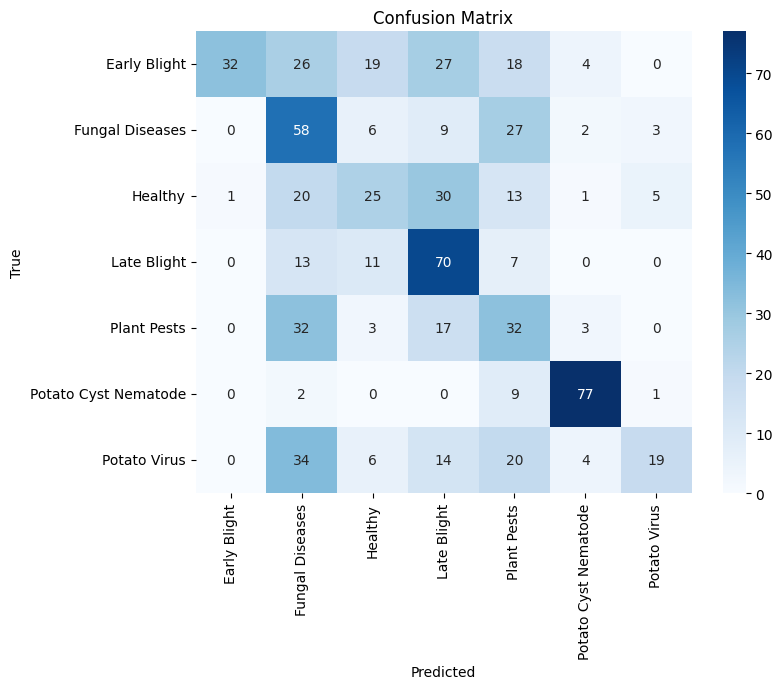

In [9]:
cm = confusion_matrix(Y_test, Y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Karar Ağaçları

In [10]:
dt_model = DecisionTreeClassifier(random_state=seed)
dt_model.fit(X_train, Y_train)

Y_pred = dt_model.predict(X_test)

In [11]:
print("Decision Tree Model Results:")
print("Accuracy:", accuracy_score(Y_test, Y_pred))
print("F1 Score:", f1_score(Y_test, Y_pred, average='macro'))
print("Precision:", precision_score(Y_test, Y_pred, average='macro'))
print("Recall:", recall_score(Y_test, Y_pred, average='macro'))

Decision Tree Model Results:
Accuracy: 0.42857142857142855
F1 Score: 0.429675078015642
Precision: 0.4318563676556449
Recall: 0.4297971875310069


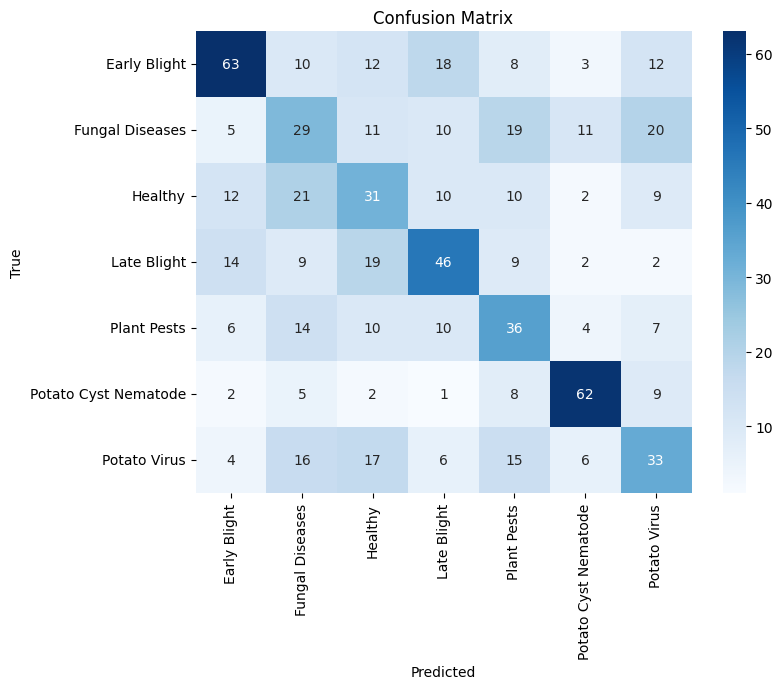

In [12]:
cm = confusion_matrix(Y_test, Y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Random Forest

In [13]:
# Random Forest modeli için parametre aralıkları
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_model = RandomForestClassifier(random_state=seed)
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=2, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train, Y_train)

Fitting 2 folds for each of 81 candidates, totalling 162 fits


GridSearchCV(cv=2, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy', verbose=1)

In [14]:
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score (Accuracy): {:.2f}".format(grid_search.best_score_))

best_rf_model = grid_search.best_estimator_
Y_pred = best_rf_model.predict(X_test)

Best Parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Best Cross-Validation Score (Accuracy): 0.61


In [15]:
print("\nRandom Forest Model Results:")
print("Test Accuracy:", accuracy_score(Y_test, Y_pred))
print("F1 Score:", f1_score(Y_test, Y_pred, average='macro'))
print("Precision:", precision_score(Y_test, Y_pred, average='macro'))
print("Recall:", recall_score(Y_test, Y_pred, average='macro'))


Random Forest Model Results:
Test Accuracy: 0.6471428571428571
F1 Score: 0.6406890089854763
Precision: 0.6549680577708303
Recall: 0.6468097522675567


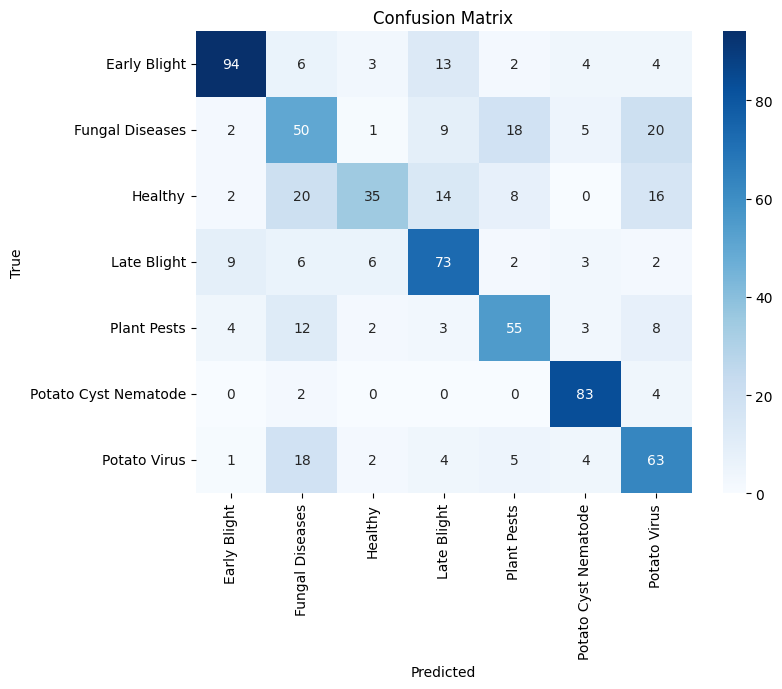

In [16]:
cm = confusion_matrix(Y_test, Y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Support Vector Classifier

In [17]:
# SVC modeli için parametre dağılımları belirleme
param_dist = {
    'C': reciprocal(0.1, 10),  # C parametresi için ters dörtgen dağılım
    'kernel': ['linear', 'rbf'],  # Çekirdek fonksiyonları
    'gamma': reciprocal(0.001, 0.1)  # Gamma parametresi için ters dörtgen dağılım
}

svc_model = SVC(random_state=seed)
random_search = RandomizedSearchCV(estimator=svc_model, param_distributions=param_dist, n_iter=20, cv=3, scoring='accuracy', verbose=2, random_state=seed, n_jobs=-1)
random_search.fit(X_train, Y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END C=0.5611516415334505, gamma=0.07969454818643935, kernel=linear; total time= 5.4min
[CV] END C=0.2051110418843398, gamma=0.0013066739238053278, kernel=rbf; total time= 8.2min
[CV] END C=0.2051110418843398, gamma=0.0013066739238053278, kernel=rbf; total time= 8.6min
[CV] END C=0.10994335574766201, gamma=0.08706020878304858, kernel=rbf; total time= 8.9min
[CV] END C=0.2327067708383781, gamma=0.0040596116104843075, kernel=rbf; total time= 9.0min
[CV] END C=0.10330768043240408, gamma=0.0011120513715710634, kernel=linear; total time= 5.2min
[CV] END C=1.6738085788752133, gamma=0.0019010245319870357, kernel=rbf; total time= 8.6min
[CV] END C=3.7183641805732095, gamma=0.002508115686045232, kernel=linear; total time= 5.0min
[CV] END C=3.7183641805732095, gamma=0.002508115686045232, kernel=linear; total time= 5.2min
[CV] END C=1.6409286730647923, gamma=0.002193048555664369, kernel=linear; total time= 5.2min
[CV] END C=0.106299

RandomizedSearchCV(cv=3, estimator=SVC(random_state=42), n_iter=20, n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7d30f05f7d30>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7d3126c02fb0>,
                                        'kernel': ['linear', 'rbf']},
                   random_state=42, scoring='accuracy', verbose=2)

In [18]:
print("Best Parameters:", random_search.best_params_)
print("Best Cross-Validation Score (Accuracy): {:.2f}".format(random_search.best_score_))

best_svc_model = random_search.best_estimator_
Y_pred = best_svc_model.predict(X_test)

Best Parameters: {'C': 7.535384509295546, 'gamma': 0.0010035927878780913, 'kernel': 'rbf'}
Best Cross-Validation Score (Accuracy): 0.66
[CV] END C=3.625617634576228, gamma=0.01562069367563988, kernel=rbf; total time= 9.1min
[CV] END C=0.2051110418843398, gamma=0.0013066739238053278, kernel=rbf; total time= 8.3min
[CV] END C=0.4649617447336334, gamma=0.0019307837536547137, kernel=linear; total time= 5.3min
[CV] END C=7.535384509295546, gamma=0.0010035927878780913, kernel=rbf; total time= 8.2min
[CV] END C=0.2327067708383781, gamma=0.0040596116104843075, kernel=rbf; total time= 9.0min
[CV] END C=0.10330768043240408, gamma=0.0011120513715710634, kernel=linear; total time= 5.3min
[CV] END C=8.861577452533075, gamma=0.002921074818565715, kernel=rbf; total time= 8.9min
[CV] END C=3.7183641805732095, gamma=0.002508115686045232, kernel=linear; total time= 5.3min
[CV] END C=9.25681899206688, gamma=0.008580760619921296, kernel=linear; total time= 5.0min
[CV] END C=1.6409286730647923, gamma=0.002

In [19]:
print("\nSVC Model Results:")
print("Test Accuracy:", accuracy_score(Y_test, Y_pred))
print("F1 Score:", f1_score(Y_test, Y_pred, average='macro'))
print("Precision:", precision_score(Y_test, Y_pred, average='macro'))
print("Recall:", recall_score(Y_test, Y_pred, average='macro'))


SVC Model Results:
Test Accuracy: 0.6771428571428572
F1 Score: 0.6761459663685933
Precision: 0.6819519297864802
Recall: 0.6783130367781443


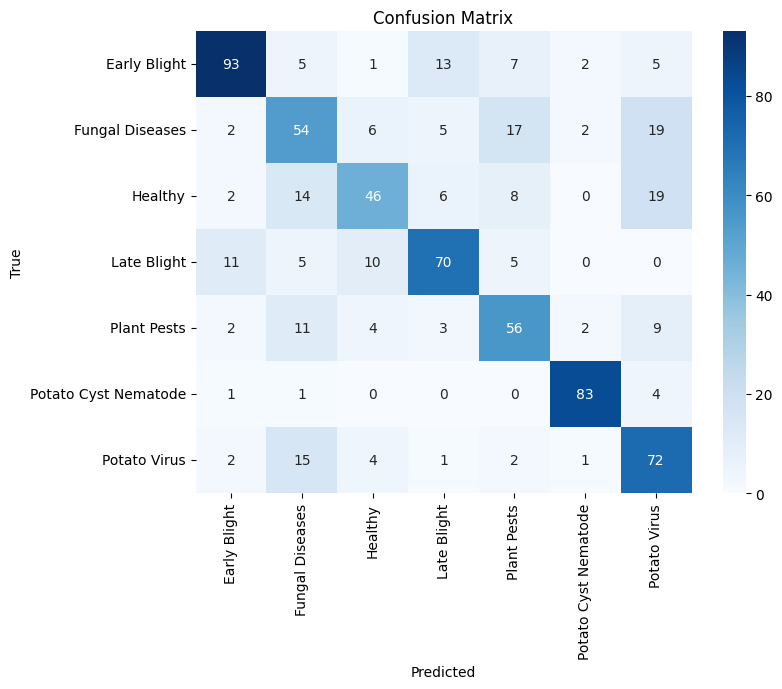

In [20]:
cm = confusion_matrix(Y_test, Y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()